Note: This work is modified from this notebook [Gaussian_Models_Final.ipynb](../Lec2/Gaussian_Models_Final.ipynb) for assignment 1 (CSI 5218).

# Bayesian Learning: Gaussian Models with Real Data
## Extended Edition with Results Discussion and Exercises

**Course:** Bayesian Learning: Single & Multi-Parameter Models
**Based on:** Chapters 2.2, 2.3, 3.3, 3.4, 3.6, 3.7

### Learning Objectives
By the end of this notebook, you will understand:
1. Plotting Gaussian
2. How **precision additivity** simplifies Bayesian updating and how **unknown variance** leads to Student-t posteriors (robustness)
3. Why **sequential updates** are efficient for streaming data
4. **Multivariate Bayesian fusion** for sensor networks

## Setup: Libraries and Configuration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, invgamma, t as student_t, multivariate_normal
from math import gamma, sqrt, pi

# Plotting settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Random seed
np.random.seed(42)

print(f"NumPy: {np.__version__}")
print(f"Matplotlib: {plt.matplotlib.__version__}")

NumPy: 2.2.6
Matplotlib: 3.10.8


# Part 1: Plotting Gaussian random numbers




In [2]:
# Simulation helper
import numpy as np

def simulate_normal(mu_true=10.0, sigma_true=2.0, n=20, seed=0):
    rng = np.random.default_rng(seed)
    x = rng.normal(loc=mu_true, scale=sigma_true, size=n).astype(np.float32)
    return x

# Example
x_sim = simulate_normal(mu_true=10.0, sigma_true=2.0, n=20, seed=1)
x_sim[:5], x_sim.mean(), x_sim.std(ddof=0)


(array([10.691169 , 11.643236 , 10.660874 ,  7.3936853, 11.810712 ],
       dtype=float32),
 np.float32(10.074974),
 np.float32(1.1543354))

## 1) Normal distribution: PDF vs CDF

The **PDF** tells you relative density at a point. The **CDF** tells you cumulative probability up to a point.

Why do we care?
- Many Bayesian models start with Gaussian assumptions.
- Understanding PDF/CDF helps interpret confidence intervals and tail probabilities.

**Goal:** compute and plot PDF/CDF, and answer questions like *P(X > 100)*.


1 - CDF at 100: 0.5792597094391023


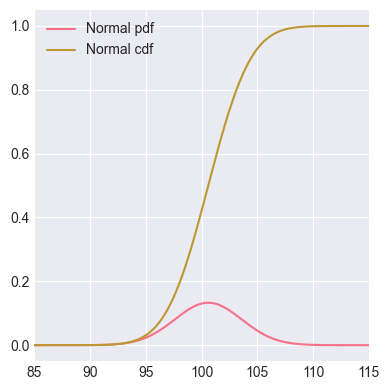

In [3]:
from pathlib import Path
import os
OUTDIR = Path(os.curdir) / "FIGURES"
def plot_normal_pdf_cdf(outdir: str = OUTDIR):
    x = np.arange(-85, 115.1, 0.1)
    mu, sigma = 100.6, 3.0
    pdf = norm.pdf(x, loc=mu, scale=sigma)
    cdf = norm.cdf(x, loc=mu, scale=sigma)

    plt.figure(figsize=(4, 4))
    plt.plot(x, pdf, label="Normal pdf")
    plt.plot(x, cdf, label="Normal cdf")
    plt.xlim(85, 115)
    plt.legend()
    plt.tight_layout()
    #plt.savefig(f"{outdir}/lec2_normal_pdf_cdf.png", dpi=150)

    print("1 - CDF at 100:", float(1.0 - norm.cdf(100.0, loc=mu, scale=sigma)))


plot_normal_pdf_cdf()

## 2) Bivariate Gaussian: what does covariance do?

A 2D Gaussian is defined by:
- a mean vector μ
- a covariance matrix Σ

The off-diagonal terms encode **correlation** (and more generally linear dependence).

**Goal:** sample from three covariance settings and see how the scatter + contours change.


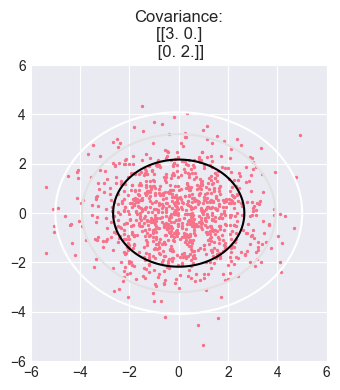

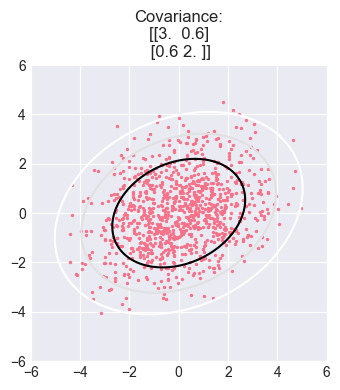

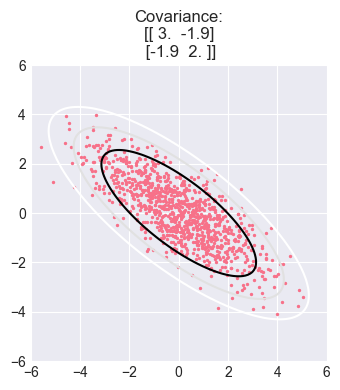

In [4]:
def plot_bivariate_normals(outdir: str = OUTDIR, seed: int = 0):
    rng = np.random.default_rng(seed)

    def plot_one(Sigma, name):
        mu = np.array([0.0, 0.0])
        N = 1000
        pts = rng.multivariate_normal(mu, Sigma, size=N)

        support = np.arange(-6, 6.1, 0.1)
        X, Y = np.meshgrid(support, support)
        rv = multivariate_normal(mean=mu, cov=Sigma)
        Z = rv.pdf(np.dstack([X, Y]))

        plt.figure(figsize=(4, 4))
        plt.title(f"Covariance:\n{Sigma}")
        plt.scatter(pts[:, 0], pts[:, 1], s=2)
        plt.contour(X, Y, Z, levels=[0.001, 0.005, 0.02])
        plt.xlim(-6, 6)
        plt.ylim(-6, 6)
        plt.gca().set_aspect("equal", adjustable="box")
        plt.tight_layout()
        #plt.savefig(f"{outdir}/lec2_bvn_{name}.png", dpi=150)

    plot_one(np.array([[3.0, 0.0], [0.0, 2.0]]), "cov0")
    plot_one(np.array([[3.0, 0.6], [0.6, 2.0]]), "cov_pos")
    plot_one(np.array([[3.0, -1.9], [-1.9, 2.0]]), "cov_neg")


plot_bivariate_normals()

# Part 2: Gaussian Data with A) Known and B) Unknown Variance
## Example: Internet speed measurement

We measure download speed 5 times (Mbps):
x = {15.77, 20.5, 8.26, 14.37, 21.09}

ISP claims average is 20 Mbps. We model measurements as:
$x_i$ | μ, σ² ~ Normal(μ, σ²)

We compare two cases:

**A) Known measurement noise σ**
- Prior: μ ~ Normal(μ0, σ0²)
- Posterior: μ | x ~ Normal($μ_n$, $σ_n²$)

**B) Unknown measurement noise σ²**
- Use a conjugate prior on precision λ = 1/σ²:
  λ ~ Gamma(α0, β0)  (shape-rate)
  μ | λ ~ Normal(μ0, 1/(κ0 λ))
- Posterior: (μ, λ) | x is Normal-Gamma
- Marginal posterior: μ | x is Student-t (heavier tails than Gaussian)

Goal:
1) Compute posteriors analytically
2) Simulate draws from posterior in both cases
3) Visualize why Student-t appears when σ² is unknown
4) Compare credible intervals and tail probabilities


In [5]:
# Data
x = np.array([15.77, 20.5, 8.26, 14.37, 21.09])
n = len(x)
xbar = x.mean()

# Given in slide
mu0 = 20.0
sigma0 = 5.0

print("n =", n)
print("xbar =", xbar)


n = 5
xbar = 15.998


In [6]:
# --- Case A: known measurement noise sigma ---
sigma = 5.0
lambda_lik = 1.0 / sigma**2
lambda0 = 1.0 / sigma0**2

# Posterior precision and mean (conjugate Normal-Normal)
lambda_n = lambda0 + n * lambda_lik # posterior's data precision will be more confident than prior
sigma_n2 = 1.0 / lambda_n
mu_n = (lambda0 * mu0 + n * lambda_lik * xbar) / lambda_n

print("=== Case A: Known σ ===")
print("posterior mu_n =", mu_n)
print("posterior sigma_n =", np.sqrt(sigma_n2))

# Draw posterior samples for μ
rng = np.random.default_rng(0)
S = 200000
mu_samples_A = rng.normal(loc=mu_n, scale=np.sqrt(sigma_n2), size=S)


=== Case A: Known σ ===
posterior mu_n = 16.665
posterior sigma_n = 2.0412414523193148


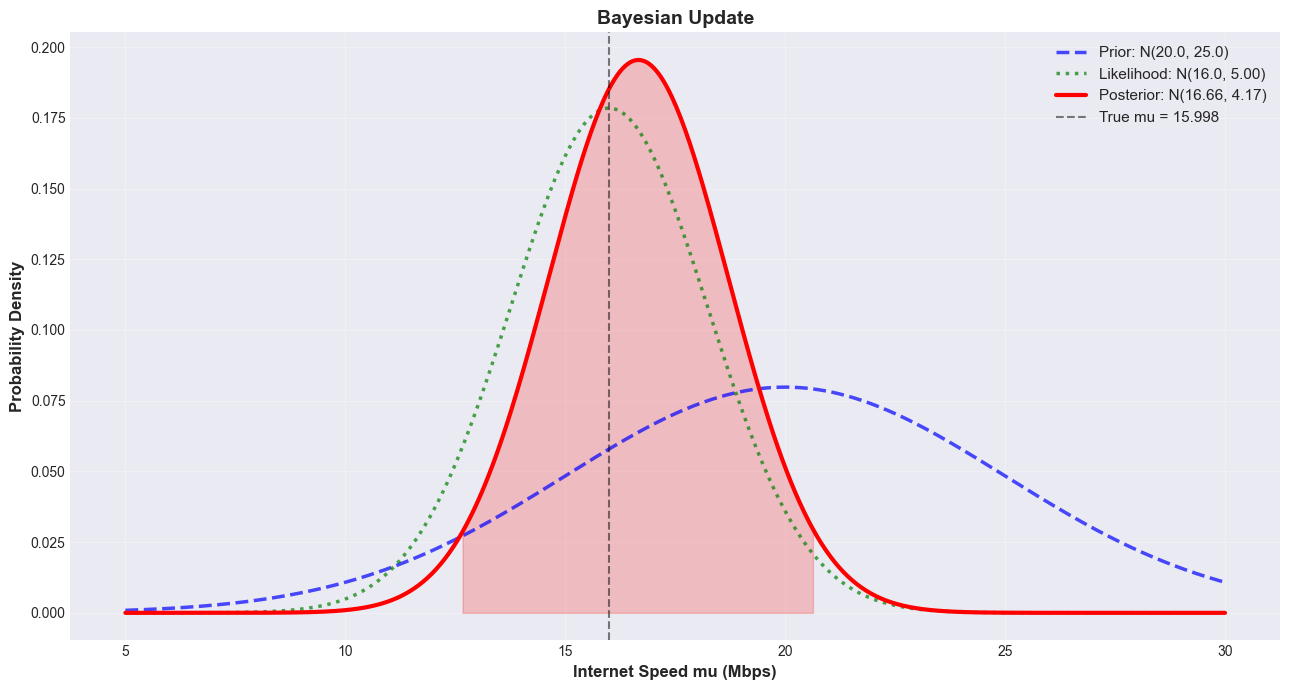

In [7]:
# Visualization: Prior, Likelihood, Posterior
mu_range = np.linspace(5, 30, 500)
prior_pdf = norm.pdf(mu_range, mu0, sigma0)
likelihood_pdf = norm.pdf(mu_range, xbar, sigma0 / np.sqrt(n))
posterior_pdf = norm.pdf(mu_range, mu_n, np.sqrt(sigma_n2))

fig, ax = plt.subplots(figsize=(13, 7))
ax.plot(mu_range, prior_pdf, 'b--', lw=2.5, label=f'Prior: N({mu0}, {sigma0**2:.1f})', alpha=0.7)
ax.plot(mu_range, likelihood_pdf, 'g:', lw=2.5,
        label=f'Likelihood: N({xbar:.1f}, {sigma0**2/n:.2f})', alpha=0.7)
ax.plot(mu_range, posterior_pdf, 'r-', lw=3, label=f'Posterior: N({mu_n:.2f}, {sigma_n2:.2f})')
ax.fill_between(mu_range, 0, posterior_pdf,
                 where=(mu_range >= mu_n - 1.96*np.sqrt(sigma_n2)) & (mu_range <= mu_n + 1.96*np.sqrt(sigma_n2)),
                 alpha=0.2, color='red')
ax.axvline(xbar, color='black', linestyle='--', alpha=0.5, label=f'True mu = {xbar}')

ax.set_xlabel('Internet Speed mu (Mbps)', fontsize=12, fontweight='bold')
ax.set_ylabel('Probability Density', fontsize=12, fontweight='bold')
ax.set_title('Bayesian Update', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='upper right')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [8]:
# --- Case B: unknown variance using Normal-Gamma prior on (μ, λ) ---
# Prior hyperparameters
kappa0 = 1.0
alpha0 = 2.5
beta0 = alpha0 * sigma0**2  # so E[lambda] = alpha0/beta0 = 1/sigma0^2

# Sufficient statistics
Sxx = np.sum((x - xbar)**2)

# Posterior Normal-Gamma updates
kappa_n = kappa0 + n
mu_n_B = (kappa0 * mu0 + n * xbar) / kappa_n
alpha_n = alpha0 + n / 2.0
beta_n = beta0 + 0.5 * (Sxx + (kappa0 * n / kappa_n) * (xbar - mu0)**2)

# Marginal posterior for μ is Student-t with:
nu = 2.0 * alpha_n
scale2 = beta_n / (alpha_n * kappa_n)   # σ_t^2 parameter (scale^2)
scale = np.sqrt(scale2)

print("=== Case B: Unknown σ² ===")
print("posterior mu_n (location) =", mu_n_B)
print("posterior df nu =", nu)
print("posterior scale =", scale)

# Sample from the marginal μ|x by sampling λ and then μ|λ
# λ | x ~ Gamma(alpha_n, beta_n) with shape-rate (rate=beta_n)
lambda_samples = rng.gamma(shape=alpha_n, scale=1.0/beta_n, size=S)  # numpy uses scale=1/rate
mu_samples_B = rng.normal(loc=mu_n_B, scale=np.sqrt(1.0/(kappa_n*lambda_samples)), size=S)


=== Case B: Unknown σ² ===
posterior mu_n (location) = 16.665
posterior df nu = 10.0
posterior scale = 2.0294586716659198


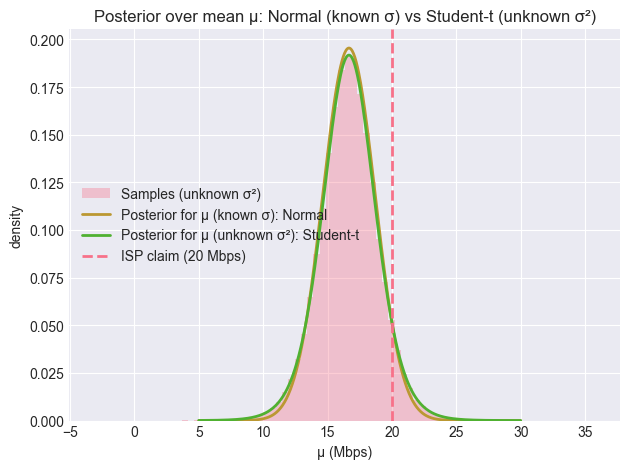

In [9]:
def normal_pdf(x, m, s):
    return (1.0/(np.sqrt(2*np.pi)*s)) * np.exp(-0.5*((x-m)/s)**2)

def student_t_pdf(x, nu, m, s):
    # location m, scale s (NOT variance)
    # pdf = Gamma((nu+1)/2) / (sqrt(nu*pi)*Gamma(nu/2)*s) * (1 + ((x-m)/s)^2/nu)^(-(nu+1)/2)
    c = gamma((nu+1)/2.0) / (np.sqrt(nu*np.pi) * gamma(nu/2.0) * s)
    return c * (1.0 + ((x-m)/s)**2 / nu) ** (-(nu+1)/2.0)

# Grid
grid = np.linspace(5, 30, 500)

# PDFs
pdf_A = normal_pdf(grid, mu_n, np.sqrt(sigma_n2))
pdf_B = student_t_pdf(grid, nu, mu_n_B, scale)

plt.figure()
plt.hist(mu_samples_B, bins=80, density=True, alpha=0.35, label="Samples (unknown σ²)")
plt.plot(grid, pdf_A, linewidth=2, label="Posterior for μ (known σ): Normal")
plt.plot(grid, pdf_B, linewidth=2, label="Posterior for μ (unknown σ²): Student-t")

plt.axvline(20, linestyle="--", linewidth=2, label="ISP claim (20 Mbps)")
plt.title("Posterior over mean μ: Normal (known σ) vs Student-t (unknown σ²)")
plt.xlabel("μ (Mbps)")
plt.ylabel("density")
plt.legend()
plt.tight_layout()
plt.show()


In [10]:
def cred_int(samples, level=0.95):
    lo = np.quantile(samples, (1-level)/2)
    hi = np.quantile(samples, 1 - (1-level)/2)
    return lo, hi

ci_A = cred_int(mu_samples_A, 0.95)
ci_B = cred_int(mu_samples_B, 0.95)

pA_gt20 = np.mean(mu_samples_A > 20)
pB_gt20 = np.mean(mu_samples_B > 20)

print("=== 95% credible intervals for μ ===")
print("Known σ (Normal posterior):     ", ci_A)
print("Unknown σ² (Student-t marginal):", ci_B)
print()
print("P(μ > 20 | data)")
print("Known σ:", pA_gt20)
print("Unknown σ²:", pB_gt20)


=== 95% credible intervals for μ ===
Known σ (Normal posterior):      (np.float64(12.662186904441805), np.float64(20.670096408632304))
Unknown σ² (Student-t marginal): (np.float64(12.145497164466777), np.float64(21.179187654409457))

P(μ > 20 | data)
Known σ: 0.05123
Unknown σ²: 0.06502


## Student Questions

### Conceptual
1. Why does the posterior for μ become Student-t when σ² is unknown, but remains Normal when σ² is known?
- Because σ² is the variance that controls the spread of data. Known σ² means the uncertainty is relatively predictable, where outliers are not likely occur in the distribution. 
2. In the unknown-σ² case, explain how uncertainty in σ² leads to heavier tails in μ. What kind of robustness does that give?
- With a larger σ², there is a higher chance where many outliers occur. The model should try to **robustly** cover them, resulting in heavier tails.

### Empirical / Simulation
3. Compare the 95% credible interval widths for μ in cases A and B. Which is wider and why?
4. Compute P(μ > 20 | data) in both cases. Which is larger? Provide an interpretation in terms of uncertainty.
5. Sensitivity study: change α0 (e.g., 1.5, 2.5, 10) while keeping E[λ] fixed. How does this affect the Student-t tails and the posterior uncertainty over μ?
6. What if you measured 10 times?
a. How would lambda_data change?
b. How would the posterior mean mu_n change?
c. How would the posterior standard deviation sigma_n change?
d. What's the new weight on data?


In [11]:
ci_widths = [ci_A[1] - ci_A[0], ci_B[1] - ci_B[0]]
wider_interval_dist = ["Known σ²", "Unknown σ²"][int(np.argmax(ci_widths))]
print(f"The wider 95% credible interval is from the '{wider_interval_dist}' model.")

The wider 95% credible interval is from the 'Unknown σ²' model.


In [12]:
prob_greater_true_mu_sample_A = len(mu_samples_A[mu_samples_A > 20]) / len(mu_samples_A)
prob_greater_true_mu_sample_B = len(mu_samples_B[mu_samples_B > 20]) / len(mu_samples_B)
print("Probability that μ > 20 in Sample A (Known σ):", prob_greater_true_mu_sample_A)
print("Probability that μ > 20 in Sample B (Unknown σ):", prob_greater_true_mu_sample_B)
greater_probs = ["Known σ", "Unknown σ²"][int(np.argmax([prob_greater_true_mu_sample_A, prob_greater_true_mu_sample_B]))]
print(f"The model with greater probability that μ > 20 is: {greater_probs}")

Probability that μ > 20 in Sample A (Known σ): 0.05123
Probability that μ > 20 in Sample B (Unknown σ): 0.06502
The model with greater probability that μ > 20 is: Unknown σ²


Unknown σ² has a higher chance with μ > 20, because it probably consists of more outliers in the distribution, resulting in higher variance.

In [13]:
# Sensitivity Analysis: Change α0, Keep E[λ]
for new_alpha_0 in [1.0, 5.0]: # [less, more]
    is_more = "more" if new_alpha_0 > alpha0 else "less"
    print(f"\n--- Sensitivity Analysis: alpha0 = {new_alpha_0} ({is_more})---")
    # Recompute Normal-Gamma posterior with updated mu0 and check Student-t tail
    Sxx = np.sum((x - xbar) ** 2)

    kappa_n = kappa0 + n
    mu_n_B = (kappa0 * mu0 + n * xbar) / kappa_n
    alpha_n = new_alpha_0 + n / 2.0
    beta_n = beta0 + 0.5 * (Sxx + (kappa0 * n / kappa_n) * (xbar - mu0) ** 2)

    nu = 2.0 * alpha_n
    scale2 = beta_n / (alpha_n * kappa_n)
    scale = np.sqrt(scale2)

    tail_at_20 = 1.0 - student_t.cdf(20.0, df=nu, loc=mu_n_B, scale=scale)
    tail_at_25 = 1.0 - student_t.cdf(25.0, df=nu, loc=mu_n_B, scale=scale)

    print("Updated Student-t params:")
    print(f"  mu_n = {mu_n_B:.3f}, nu = {nu:.2f}, scale = {scale:.3f}")
    print("Tail probabilities (Student-t):")
    print(f"  P(mu > 20) = {tail_at_20:.4f}")
    print(f"  P(mu > 25) = {tail_at_25:.4f}")


--- Sensitivity Analysis: alpha0 = 1.0 (less)---
Updated Student-t params:
  mu_n = 16.665, nu = 7.00, scale = 2.426
Tail probabilities (Student-t):
  P(mu > 20) = 0.1058
  P(mu > 25) = 0.0054

--- Sensitivity Analysis: alpha0 = 5.0 (more)---
Updated Student-t params:
  mu_n = 16.665, nu = 15.00, scale = 1.657
Tail probabilities (Student-t):
  P(mu > 20) = 0.0312
  P(mu > 25) = 0.0001


Narrower Tail when α0 is increased. wider Tail when α0 is decreased.

Posterior mu_n: 9.792, Posterior std: 1.091, P(mu > 10): 0.4259
Posterior mu_n_B: 9.792, Posterior scale: 1.029, P(mu > 10): 0.4213
Weights: Known σ weight = 0.952.
Unknown σ² weight = 0.952
Wider 95% CI: Known σ², Higher P(mu > 20): Known σ

Posterior mu_n: 10.549, Posterior std: 1.091, P(mu > 10): 0.6920
Posterior mu_n_B: 10.549, Posterior scale: 1.025, P(mu > 10): 0.7033
Weights: Known σ weight = 0.952.
Unknown σ² weight = 0.952
Wider 95% CI: Known σ², Higher P(mu > 20): Unknown σ²

Posterior mu_n: 11.405, Posterior std: 1.091, P(mu > 10): 0.9015
Posterior mu_n_B: 11.405, Posterior scale: 1.331, P(mu > 10): 0.8483
Weights: Known σ weight = 0.952.
Unknown σ² weight = 0.952
Wider 95% CI: Unknown σ², Higher P(mu > 20): Known σ

Posterior mu_n: 12.148, Posterior std: 1.091, P(mu > 10): 0.9755
Posterior mu_n_B: 12.148, Posterior scale: 1.053, P(mu > 10): 0.9735
Weights: Known σ weight = 0.952.
Unknown σ² weight = 0.952
Wider 95% CI: Unknown σ², Higher P(mu > 20): Known σ

Posterior mu_n:

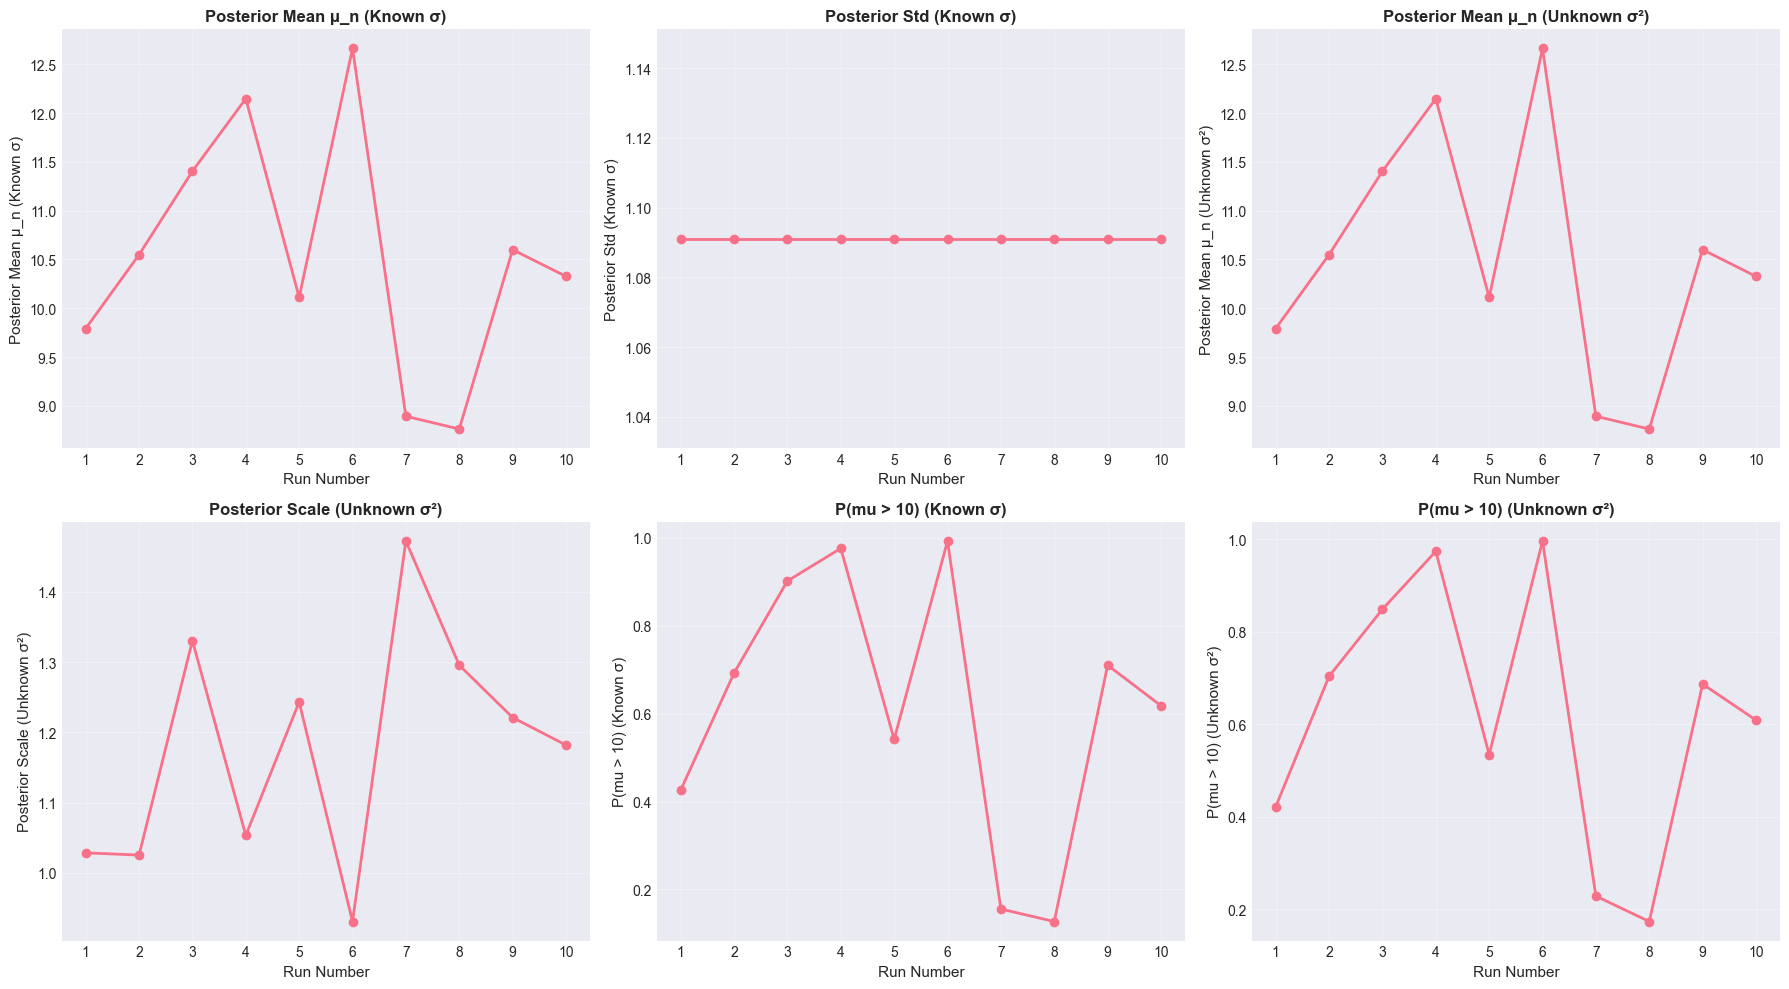

In [14]:
# Run 10 times to see change of mu_n, posterior std (sigma_n), new weights, and P(mu > 20)
snapshots = []
for _ in range(10):
    # Simulate new data
    x = simulate_normal(mu_true=10.0, sigma_true=5.0, n=20, seed=None)
    n = len(x)
    xbar = x.mean()

    # --- Case A: known measurement noise sigma ---
    sigma = 5.0
    lambda_lik = 1.0 / sigma**2
    lambda0 = 1.0 / sigma0**2

    # Posterior precision and mean (conjugate Normal-Normal)
    lambda_n = lambda0 + n * lambda_lik # posterior's data precision will be more confident than prior
    sigma_n2 = 1.0 / lambda_n
    mu_n = (lambda0 * mu0 + n * lambda_lik * xbar) / lambda_n

    # Draw posterior samples for μ
    rng = np.random.default_rng()
    S = 200000
    mu_samples_A = rng.normal(loc=mu_n, scale=np.sqrt(sigma_n2), size=S)

    # Case B: unknown variance using Normal-Gamma prior on (μ, λ) ---
    # Prior hyperparameters
    kappa0 = 1.0
    alpha0 = 2.5
    beta0 = alpha0 * sigma0**2  # so E[lambda] = alpha0/beta0 = 1/sigma0^2
    # Sufficient statistics
    Sxx = np.sum((x - xbar)**2)
    # Posterior Normal-Gamma updates
    kappa_n = kappa0 + n
    mu_n_B = (kappa0 * mu0 + n * xbar) / kappa_n
    alpha_n = alpha0 + n / 2.0
    beta_n = beta0 + 0.5 * (Sxx + (kappa0 * n / kappa_n) * (xbar - mu0)**2)
    # Marginal posterior for μ is Student-t with:
    nu = 2.0 * alpha_n
    scale2 = beta_n / (alpha_n * kappa_n)   # σ_t^2 parameter (scale^2)
    scale = np.sqrt(scale2)
    # Sample from the marginal μ|x by sampling λ and then μ|λ
    lambda_samples = rng.gamma(shape=alpha_n, scale=1.0/beta_n, size=S)  # numpy uses scale=1/rate
    mu_samples_B = rng.normal(loc=mu_n_B, scale=np.sqrt(1.0/(kappa_n*lambda_samples)), size=S)

    # Check probs
    check_margin = 10
    prob_greater_true_mu_sample_A = len(mu_samples_A[mu_samples_A > check_margin]) / len(mu_samples_A)
    prob_greater_true_mu_sample_B = len(mu_samples_B[mu_samples_B > check_margin]) / len(mu_samples_B)
    print(f"Posterior mu_n: {mu_n:.3f}, Posterior std: {np.sqrt(sigma_n2):.3f}, P(mu > {check_margin}): {prob_greater_true_mu_sample_A:.4f}")
    print(f"Posterior mu_n_B: {mu_n_B:.3f}, Posterior scale: {scale:.3f}, P(mu > {check_margin}): {prob_greater_true_mu_sample_B:.4f}")
    snapshots.append({
        "true_mu": xbar,
        "mu_n_A": mu_n,
        "posterior_A": np.sqrt(sigma_n2),
        f"p_gt{check_margin}_A": prob_greater_true_mu_sample_A,
        "mu_n_B": mu_n_B,
        "posterior_B": scale,
        f"p_gt{check_margin}_B": prob_greater_true_mu_sample_B
    })
    ismore = "Known σ" if prob_greater_true_mu_sample_A > prob_greater_true_mu_sample_B else "Unknown σ²"

    print(f"Weights: Known σ weight = {n * lambda_lik / (lambda0 + n * lambda_lik):.3f}.\nUnknown σ² weight = {n / (kappa0 + n):.3f}")

    # Check CI Widths
    ci_A = cred_int(mu_samples_A, 0.95)
    ci_B = cred_int(mu_samples_B, 0.95)
    ci_widths = [ci_A[1] - ci_A[0], ci_B[1] - ci_B[0]]
    wider_interval_dist = ["Known σ²", "Unknown σ²"][int(np.argmax(ci_widths))]
    print(f"Wider 95% CI: {wider_interval_dist}, Higher P(mu > 20): {ismore}\n")

# Plot snapshots - create 6 separate line plots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Extract keys from first snapshot
keys = list(snapshots[0].keys())
runs = list(range(1, len(snapshots) + 1))

# Create 6 plots (skipping 'true_mu' as it's not a model parameter)
plot_keys = ['mu_n_A', 'posterior_A', 'mu_n_B', 'posterior_B', f"p_gt{check_margin}_A", f"p_gt{check_margin}_B"]
titles = [
    'Posterior Mean μ_n (Known σ)',
    'Posterior Std (Known σ)',
    'Posterior Mean μ_n (Unknown σ²)',
    'Posterior Scale (Unknown σ²)',
    f'P(mu > {check_margin}) (Known σ)',
    f'P(mu > {check_margin}) (Unknown σ²)'
]

for idx, (key, title) in enumerate(zip(plot_keys, titles)):
    values = [snap[key] for snap in snapshots]
    axes[idx].plot(runs, values, marker='o', linewidth=2, markersize=6)
    axes[idx].set_xlabel('Run Number', fontsize=11)
    axes[idx].set_ylabel(title, fontsize=11)
    axes[idx].set_title(title, fontsize=12, fontweight='bold')
    axes[idx].grid(alpha=0.3)
    axes[idx].set_xticks(runs)

plt.tight_layout()
plt.show()

---

# Part 3: Online Learning (Sequential Updates)
## Example: Temperature sensor over time

Noisy temperature sensor, true temperature $\mu = 22°$C. \
Measurement noise: $\sigma = 1.5°$C $\Rightarrow$ $\lambda = 0.444$. \
Prior: $\mu_0 = 20°$C, $\sigma_0 = 3°$C $\Rightarrow$ $\lambda_0 = 0.111$. \
20 sequential readings, typical values: $\{20.1, 22.3, 21.8, 23.1, \ldots\}$.

The objective is to find the posterior mean and the credible intervals after each measurement.

## Assignment 1 - Part 2

In [15]:
def plot_online_learning(mu_history, sigma_history, lambda_history, learning_rate_history, true_temp, n_readings):
    # 4-panel visualization of online learning
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Panel 1: Posterior mean convergence
    ax = axes[0, 0]
    ax.plot(mu_history, 'b-o', markersize=6, linewidth=2, label='Posterior Mean')
    ax.axhline(true_temp, color='red', linestyle='--', linewidth=2, label=f'True Temp = {true_temp}C')
    ax.fill_between(range(len(mu_history)),
                    np.array(mu_history) - 1.96*np.array(sigma_history),
                    np.array(mu_history) + 1.96*np.array(sigma_history),
                    alpha=0.2, color='blue', label='95% Credible Interval')
    ax.set_xlabel('Observation Number', fontsize=11, fontweight='bold')
    ax.set_ylabel('Temperature (C)', fontsize=11, fontweight='bold')
    ax.set_title('1. Posterior Mean Convergence', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)

    # Panel 2: Precision growth (LINEAR!)
    ax = axes[0, 1]
    ax.plot(lambda_history, 'g-o', markersize=6, linewidth=2)
    ax.set_xlabel('Observation Number', fontsize=11, fontweight='bold')
    ax.set_ylabel('Precision lambda_n', fontsize=11, fontweight='bold')
    ax.set_title('2. Precision Grows Linearly (Additivity)', fontsize=12, fontweight='bold')
    ax.grid(alpha=0.3)

    # Panel 3: Learning rate decay
    ax = axes[1, 0]
    ax.plot(range(1, n_readings+1), learning_rate_history, 'r-o', markersize=6, linewidth=2)
    ax.set_xlabel('Observation Number', fontsize=11, fontweight='bold')
    ax.set_ylabel('Learning Rate w_n', fontsize=11, fontweight='bold')
    ax.set_title('3. Learning Rate Decays (Diminishing Returns)', fontsize=12, fontweight='bold')
    ax.grid(alpha=0.3)
    ax.set_ylim([0, 1])

    # Panel 4: Posterior variance shrinkage
    ax = axes[1, 1]
    ax.plot(np.array(sigma_history)**2, 'm-o', markersize=6, linewidth=2)
    ax.set_xlabel('Observation Number', fontsize=11, fontweight='bold')
    ax.set_ylabel('Posterior Variance sigma_n^2', fontsize=11, fontweight='bold')
    ax.set_title('4. Variance Shrinks (Monotonic)', fontsize=12, fontweight='bold')
    ax.grid(alpha=0.3)

    plt.suptitle('Online Learning Dynamics: Sequential Bayesian Updates',
                fontsize=15, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()


=== Online Learning with sensor noise σ = 1.5 ===

ONLINE LEARNING: Sequential Temperature Updates

Initial prior: mu = 20.0C, sigma = 3.0C

After 20 sequential measurements:
  Final posterior: mu = 22.39C, sigma = 0.333C
  True temperature: 22.00C

Learning rate progress:
  First observation: w_1 = 0.800 (move 80% toward data)
  Last observation: w_20 = 0.049 (move 5% toward data)

-> Learning rate DECAYS: already confident, so new data matters less

=== Online Learning with sensor noise σ = 0.5 ===

ONLINE LEARNING: Sequential Temperature Updates

Initial prior: mu = 20.0C, sigma = 3.0C

After 20 sequential measurements:
  Final posterior: mu = 22.14C, sigma = 0.112C
  True temperature: 22.00C

Learning rate progress:
  First observation: w_1 = 0.973 (move 80% toward data)
  Last observation: w_20 = 0.050 (move 5% toward data)

-> Learning rate DECAYS: already confident, so new data matters less

=== Online Learning with sensor noise σ = 3.0 ===

ONLINE LEARNING: Sequential Temperat

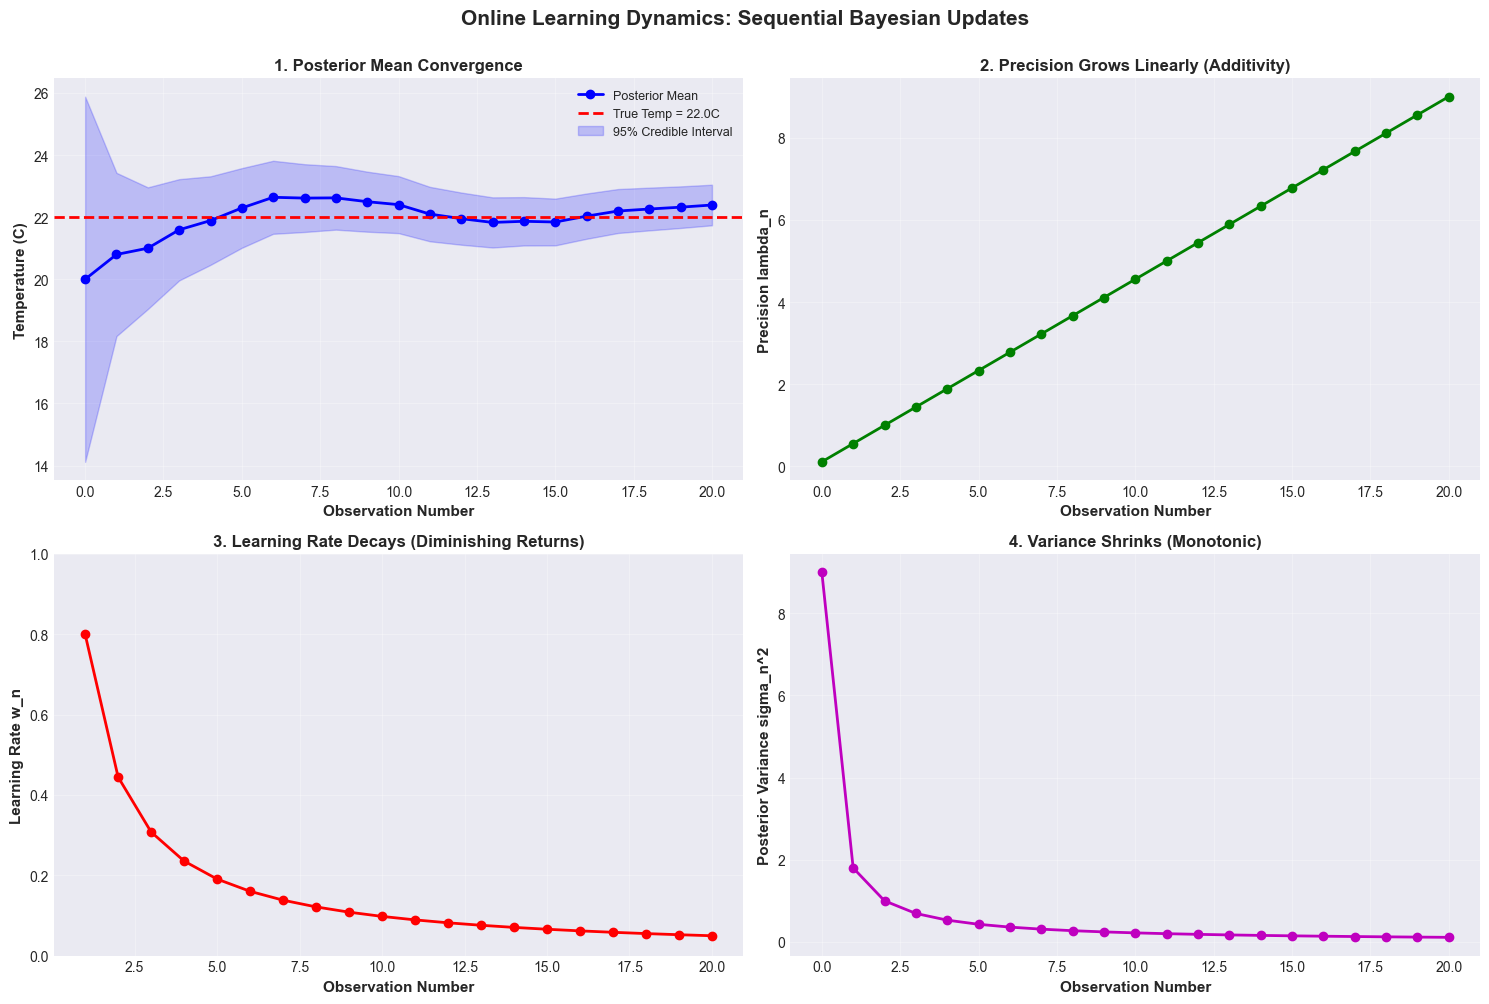



--- Plotting Online Learning with sensor noise σ = 0.5 ---


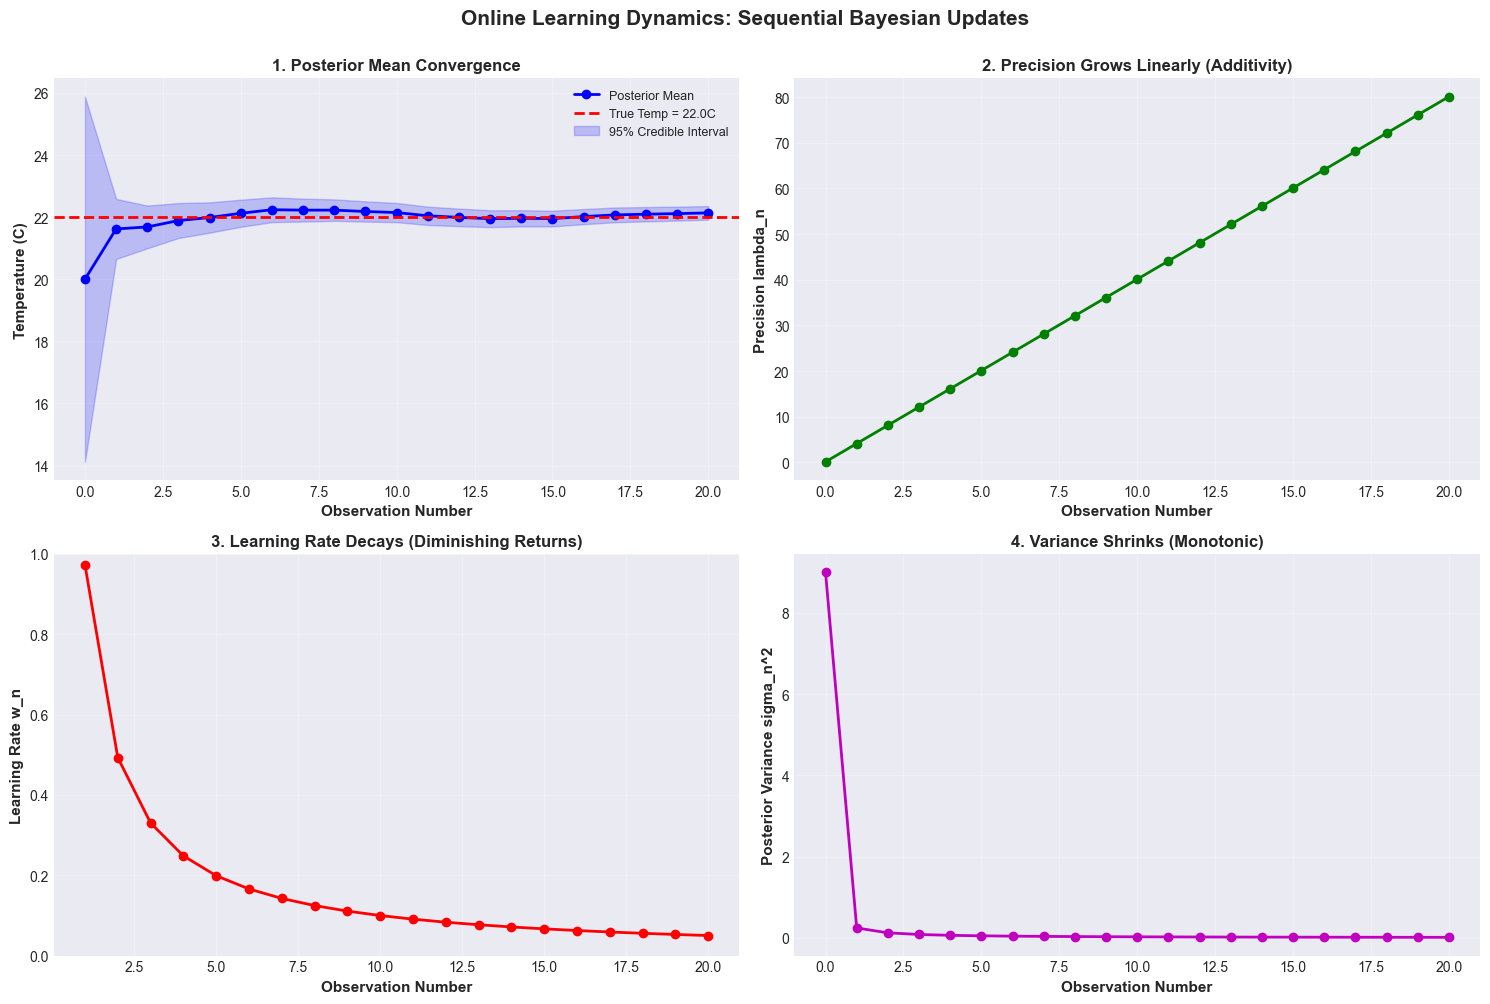



--- Plotting Online Learning with sensor noise σ = 3.0 ---


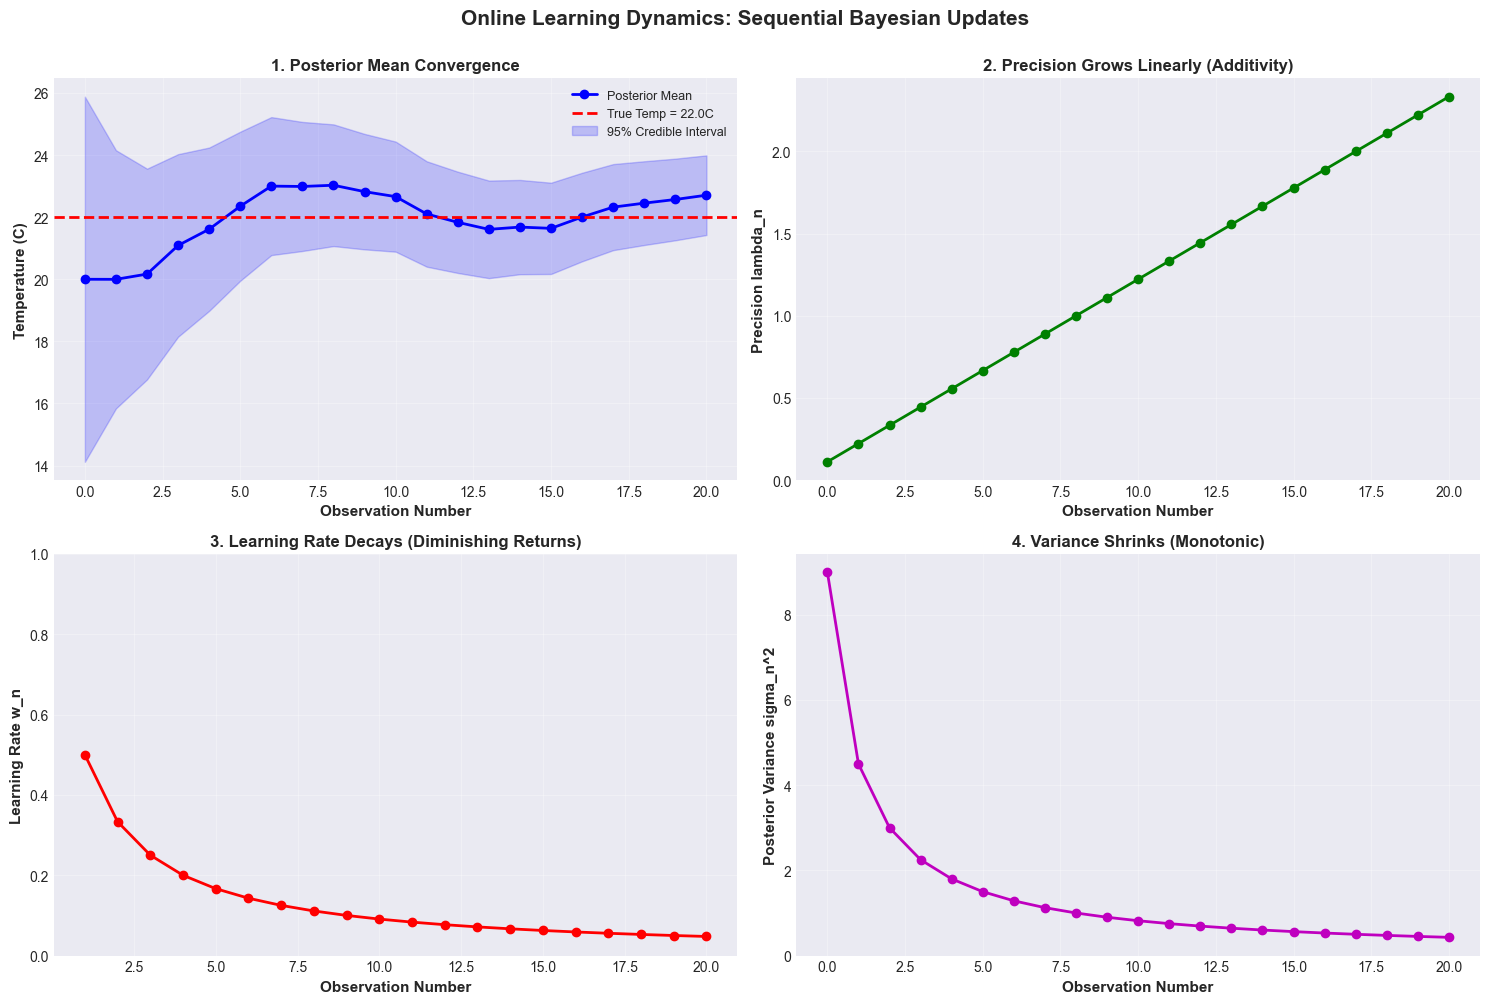

In [16]:
snapshots = []
for sensor_noise in [1.5, 0.5, 3.0]:  # Known measurement error
    # Extended as a loop for easier comparison
    print(f"\n=== Online Learning with sensor noise σ = {sensor_noise} ===")
    # Example: Temperature sensor over 20 hours
    true_temp = 22.0  # Celsius
    n_readings = 20

    np.random.seed(456)
    temp_readings = np.random.normal(true_temp, sensor_noise, n_readings)

    # Initial prior (haven't measured anything yet)
    mu_prior = 20.0
    sigma_prior = 3.0
    lambda_prior = 1 / sigma_prior**2

    # Online update: store COMPLETE HISTORY
    mu_history = [mu_prior]
    sigma_history = [sigma_prior]
    lambda_history = [lambda_prior]
    learning_rate_history = []

    mu_current = mu_prior
    lambda_current = lambda_prior

    for t, x_t in enumerate(temp_readings, 1):
        # Recursive update of precision
        lambda_new = lambda_current + 1 / sensor_noise**2

        # Learning rate (how much we move toward new observation)
        w_t = (1 / sensor_noise**2) / lambda_new
        learning_rate_history.append(w_t)

        # Recursive update of mean
        mu_new = mu_current + w_t * (x_t - mu_current)

        # Store for visualization
        mu_history.append(mu_new)
        lambda_history.append(lambda_new)
        sigma_history.append(np.sqrt(1 / lambda_new))

        # Update for next iteration
        mu_current = mu_new
        lambda_current = lambda_new

    print("\n" + "="*60)
    print("ONLINE LEARNING: Sequential Temperature Updates")
    print("="*60)
    print(f"\nInitial prior: mu = {mu_prior:.1f}C, sigma = {sigma_prior:.1f}C")
    print(f"\nAfter {n_readings} sequential measurements:")
    print(f"  Final posterior: mu = {mu_history[-1]:.2f}C, sigma = {sigma_history[-1]:.3f}C")
    print(f"  True temperature: {true_temp:.2f}C")
    print(f"\nLearning rate progress:")
    print(f"  First observation: w_1 = {learning_rate_history[0]:.3f} (move 80% toward data)")
    print(f"  Last observation: w_20 = {learning_rate_history[-1]:.3f} (move 5% toward data)")
    print(f"\n-> Learning rate DECAYS: already confident, so new data matters less")
    snapshots.append({
        "mu_history": mu_history,
        "sigma_history": sigma_history,
        "lambda_history": lambda_history,
        "learning_rate_history": learning_rate_history,
        "sensor_noise": sensor_noise
    })

# Now plot using the full histories
for snapshot in snapshots:
    print(f"\n--- Plotting Online Learning with sensor noise σ = {snapshot['sensor_noise']} ---")
    plot_online_learning(
        mu_history=snapshot['mu_history'],
        sigma_history=snapshot['sigma_history'],
        lambda_history=snapshot['lambda_history'],
        learning_rate_history=snapshot['learning_rate_history'],
        true_temp=true_temp,
        n_readings=n_readings
    )
    print()

# Question 2
## 7(a) - Observations
### Posterior Mean
#### Uncertainty Band
σ controls how wide the uncertainty band is around the posterior mean estimation.
With smaller σ, the band is narrower and closer to the estimated line; whereas,
with larger σ, the band is wider and circles more temperature values around the estimation.

#### Convergence
As the observation number grows, the posterior mean tends to be closer to the true temperature = 22.0 C.
With a narrower σ, it converges closer to the true temperature. 

### Precision
The precision is an inverse of variance ($\lambda = 1/\sigma^2$).
As there are more samples being observed, precision scales linearly. 
We can infer that the variance $σ^2$, an uncertainty, diminishes linearly.
It appears to be the same trend regardless of the magnitude of σ.
Therefore, we need more samples to increase the precision of a model on a certain dataset.

### Learning rate
The learning rate diminishes exponentially as more samples being observed.
Less σ means the learning rate starts higher, whereas a larger σ means the learning rate starts lower.
It eventually converges to a point where subsequent samples will nearly make no further improvement (i.e., close to a 0-gradient).

### Variance ($\sigma^2$)
Variance also shrinks exponentially as more samples being observed.
The difference of σ is not at its starting point, but the turning point from a linear descend gradually to a logarithmic trend and to nearly 0-gradient. 
The higher σ is, the higher the converged value is, and the later the convergence starts to happen (i.e, converging with more observed samples).
This could be explained by an aleatoric noise. If the uncontrollable factor is larger, we need more data to offset the uncertainty.

# Question 2 
## 7(b) - Comment on Convergence
### Posterior Mean ($\mu_t$)
With larger noise, the measured posterior mean has a wider interval to fluctuate, 
causing it less likely to get closer to the true measurement.
It will therefore take longer to converge closer to the true value. 
### Effect on the Learning Rate (Weights)
In case of a larger noise factor (σ), although the learning rate starts converging at a lower value, it takes more samples to stabilize.

### Conclusion: Online Learning Dynamics

**The 4 Panels (from each sensor noise) Tell a Story:**

1. **Mean Convergence:** Posterior mean walks toward true value, staying within credible intervals
   - First 5 observations: large changes
   - Last 5 observations: small changes (already converged)

2. **Precision Growth:** lambda_n increases **linearly** (0.44 -> 0.89 -> 1.33 -> ...)
   - This is precision additivity in action!
   - lambda_n = lambda_0 + n/sigma^2

3. **Learning Rate Decay:** w_t = (1/sigma^2)/lambda_n decreases from 80% -> 5%
   - First observation moves mean BY 80%
   - Twentieth observation moves mean BY 5%
   - **This is how Bayesian learning naturally handles diminishing returns!**

4. **Variance Shrinkage:** sigma_n^2 falls as 1/lambda_n
   - 9.0^2 -> 4.0^2 -> 2.0^2 -> 1.0^2 -> ...
   - Uncertainty **monotonically decreases**

In [17]:
# Verify Precision Additivity
# Claim: lambda_n = lambda_0 + n/sigma^2

lambda_0_part2 = 1 / sigma_prior**2
lambda_expected = [lambda_0_part2 + t / sensor_noise**2 for t in range(n_readings+1)]

# Compare
difference = np.array(lambda_history) - np.array(lambda_expected)
print(f"Max difference between actual and formula: {np.max(np.abs(difference)):.2e}")
print(f"\nConclusion: Precision additivity verified! Check:")
for t in [0, 5, 10, 19]:
    print(f"  Time {t}: lambda = {lambda_history[t]:.4f}, expected = {lambda_expected[t]:.4f}")

Max difference between actual and formula: 6.66e-16

Conclusion: Precision additivity verified! Check:
  Time 0: lambda = 0.1111, expected = 0.1111
  Time 5: lambda = 0.6667, expected = 0.6667
  Time 10: lambda = 1.2222, expected = 1.2222
  Time 19: lambda = 2.2222, expected = 2.2222


## 8(a) Dynamic True Temperature 

In [18]:
def plot_posterior_mean_true_temp_drift(mu_history, true_temps):
    plt.figure(figsize=(10, 6))
    plt.plot(mu_history, 'b-o', markersize=6, linewidth=2, label='Posterior Mean')
    plt.plot(true_temps, 'r--', linewidth=2, label='True Temperature')
    plt.plot(np.mean(true_temps)*np.ones(len(true_temps)), 'g:', linewidth=2, label='Avg True Temp')
    plt.fill_between(range(len(mu_history)),
                     np.array(mu_history) - 1.96*np.array(sigma_history),
                     np.array(mu_history) + 1.96*np.array(sigma_history),
                     alpha=0.2, color='blue', label='95% Credible Interval')
    plt.xlabel('Observation Number', fontsize=12, fontweight='bold')
    plt.ylabel('Temperature (C)', fontsize=12, fontweight='bold')
    plt.title('Posterior Mean Tracking True Temperature Drift', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


=== Online Learning with sensor noise σ = 1.5 ===

ONLINE LEARNING: Sequential Temperature Updates

Initial prior: mu = 20.0C, sigma = 3.0C

After 20 sequential measurements:
  Final posterior: mu = 22.39C, sigma = 0.333C
  True temperature: 24.00C

Learning rate progress:
  First observation: w_1 = 0.800 (move 80% toward data)
  Last observation: w_20 = 0.049 (move 5% toward data)

-> Learning rate DECAYS: already confident, so new data matters less

=== Online Learning with sensor noise σ = 0.5 ===

ONLINE LEARNING: Sequential Temperature Updates

Initial prior: mu = 20.0C, sigma = 3.0C

After 20 sequential measurements:
  Final posterior: mu = 22.14C, sigma = 0.112C
  True temperature: 24.00C

Learning rate progress:
  First observation: w_1 = 0.973 (move 80% toward data)
  Last observation: w_20 = 0.050 (move 5% toward data)

-> Learning rate DECAYS: already confident, so new data matters less

=== Online Learning with sensor noise σ = 3.0 ===

ONLINE LEARNING: Sequential Temperat

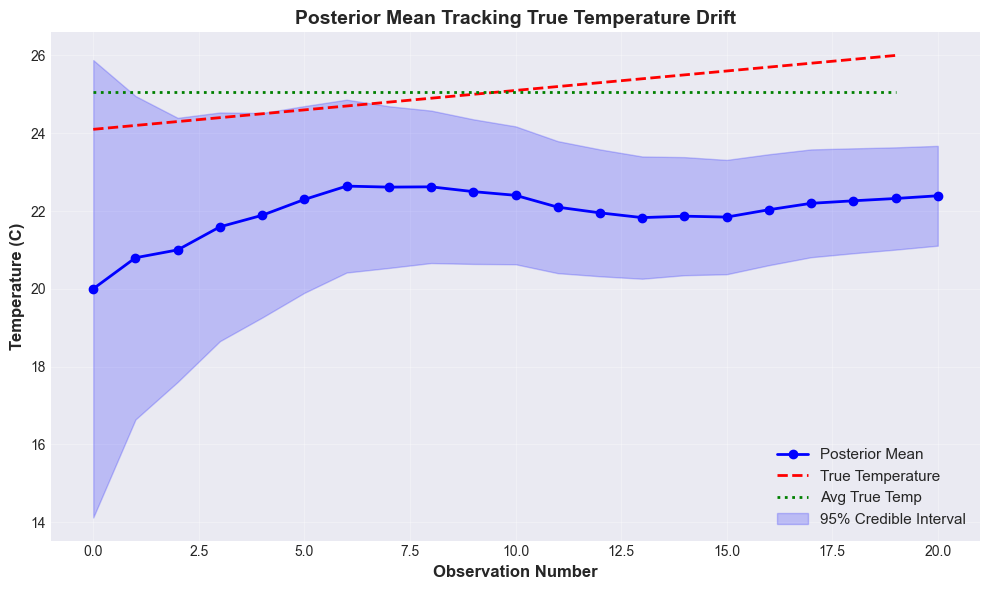



--- Plotting Online Learning with sensor noise σ = 0.5 ---


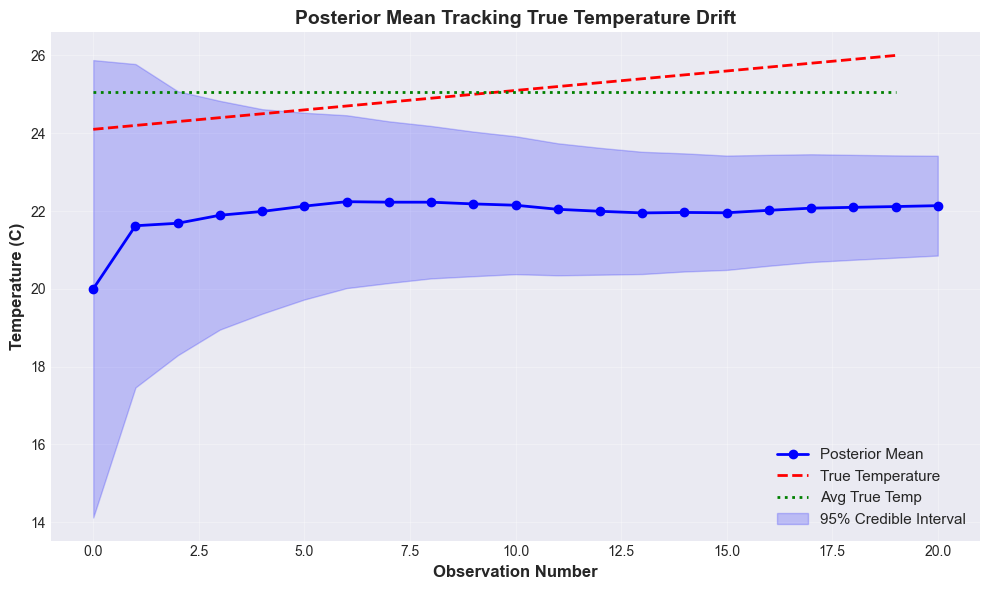



--- Plotting Online Learning with sensor noise σ = 3.0 ---


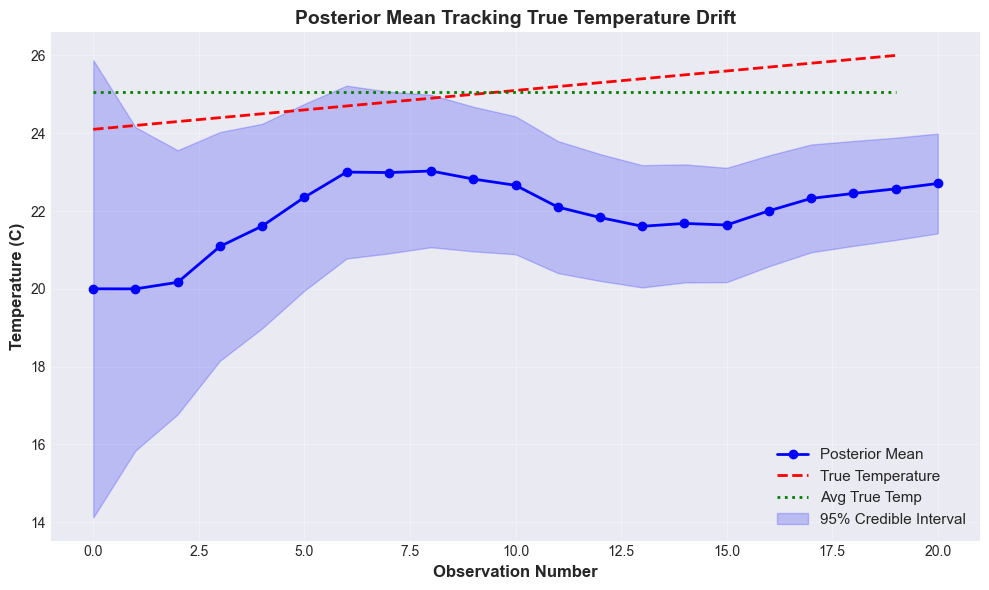

In [19]:
snapshots = []
for sensor_noise in [1.5, 0.5, 3.0]:  # Known measurement error
    # Extended as a loop for easier comparison
    print(f"\n=== Online Learning with sensor noise σ = {sensor_noise} ===")
    # Example: Temperature sensor over 20 hours
    true_temp_base = 22 # in Celsius
    n_readings = 20

    np.random.seed(456)
    temp_readings = np.random.normal(true_temp_base, sensor_noise, n_readings)

    # Initial prior (haven't measured anything yet)
    mu_prior = 20.0
    sigma_prior = 3.0
    lambda_prior = 1 / sigma_prior**2

    # Online update: store COMPLETE HISTORY
    mu_history = [mu_prior]
    sigma_history = [sigma_prior]
    lambda_history = [lambda_prior]
    learning_rate_history = []

    mu_current = mu_prior
    lambda_current = lambda_prior

    seen_data = 0
    new_temp_readings = temp_readings.copy()
    true_temps = []
    for t, x_t in enumerate(temp_readings, 1):
        seen_data += 1
        true_temp = 22.0 + 0.1 * seen_data # in Celsius (drifts over time)
        true_temps.append(true_temp)
        new_temp_readings[t-1] = np.random.normal(true_temp, sensor_noise)
        # Recursive update of precision
        lambda_new = lambda_current + 1 / sensor_noise**2

        # Learning rate (how much we move toward new observation)
        w_t = (1 / sensor_noise**2) / lambda_new
        learning_rate_history.append(w_t)

        # Recursive update of mean
        mu_new = mu_current + w_t * (x_t - mu_current)

        # Store for visualization
        mu_history.append(mu_new)
        lambda_history.append(lambda_new)
        sigma_history.append(np.sqrt(1 / lambda_new))

        # Update for next iteration
        mu_current = mu_new
        lambda_current = lambda_new

    print("\n" + "="*60)
    print("ONLINE LEARNING: Sequential Temperature Updates")
    print("="*60)
    print(f"\nInitial prior: mu = {mu_prior:.1f}C, sigma = {sigma_prior:.1f}C")
    print(f"\nAfter {n_readings} sequential measurements:")
    print(f"  Final posterior: mu = {mu_history[-1]:.2f}C, sigma = {sigma_history[-1]:.3f}C")
    print(f"  True temperature: {true_temp:.2f}C")
    print(f"\nLearning rate progress:")
    print(f"  First observation: w_1 = {learning_rate_history[0]:.3f} (move 80% toward data)")
    print(f"  Last observation: w_20 = {learning_rate_history[-1]:.3f} (move 5% toward data)")
    print(f"\n-> Learning rate DECAYS: already confident, so new data matters less")
    snapshots.append({
        "mu_history": mu_history,
        "sigma_history": sigma_history,
        "lambda_history": lambda_history,
        "learning_rate_history": learning_rate_history,
        "sensor_noise": sensor_noise,
        "true_temp": true_temps[-1], # the latest temp
        "mean_true_temp": np.mean(true_temps)
    })

# Now plot using the full histories
for snapshot in snapshots:
    print(f"\n--- Plotting Online Learning with sensor noise σ = {snapshot['sensor_noise']} ---")
    plot_posterior_mean_true_temp_drift(
        mu_history=snapshot['mu_history'],
        true_temps=snapshot['true_temp'] + 0.1 * np.arange(1, n_readings + 1)
    )
    print()

## 8(b) Discussion
### Tracking the Drift
The Bayesian learner seems struggling to keep up with the dynamic true temperature. Before introducing a drifting measurement, the learner could eventually be able to converge, and to learn to keep the posterior mean as close to the static measurement as possible, by constantly changing the weights based on the varying learning rates. Now, the learner itself is a distribution, whereas the measured value itself also forms a Bayesian Linear Regression. Solely adding more data (and thus the precision) is not enough to converge 2 variables, the learner and the measurement, at the same time. 
### Limitation
The "Uncertainty Band" could have been widened by increasing the sensor's noise. When σ = 3.0, it shows the most shaded part covering the dynamic true measurement. But then, it only allows predictions randomly bounce to the true temperature at a specific time. Introducing an aleatoric noise to the model could sometimes work, because it ensures randomness, but it fails to ensure the learner to consistently learn a specific value. 
### Suggestions
As shown by the green dotted line, we could give the learner a static measure, e.g., the mean of the drifting measurements, despite the dynamic changes. This could resume the case we've seen in 7(a). 

---

# Part 4: Multivariate Normal - Sensor Fusion
## Combining Multiple Sensors with Precision Additivity

In [20]:
# Two sensors measuring (temperature, humidity)
true_mean = np.array([22.0, 55.0])  # 22C, 55% humidity
true_cov = np.array([[2.0, 1.5],    # sigma_T^2=2, rho_TH=0.86
                      [1.5, 4.0]])   # sigma_H^2=4

n_readings = 15
np.random.seed(321)
sensor_readings = np.random.multivariate_normal(true_mean, true_cov, n_readings)

sample_mean = sensor_readings.mean(axis=0)

print("\n" + "="*60)
print("MULTIVARIATE: Bivariate Sensor Fusion")
print("="*60)
print(f"\nTrue state: [22.0C, 55.0%]")
print(f"Sample mean: [{sample_mean[0]:.2f}C, {sample_mean[1]:.1f}%]")
print(f"\nSample covariance:")
print(np.cov(sensor_readings.T))


MULTIVARIATE: Bivariate Sensor Fusion

True state: [22.0C, 55.0%]
Sample mean: [22.38C, 55.8%]

Sample covariance:
[[2.01139    0.98964106]
 [0.98964106 1.4768461 ]]


In [21]:
# Bayesian sensor fusion
mu_0_vec = np.array([20.0, 50.0])  # Prior: we think 20C, 50% humidity
Sigma_0 = np.array([[5.0, 0.0],    # Prior uncorrelated (we dont know correlation)
                     [0.0, 10.0]])
Lambda_0 = np.linalg.inv(Sigma_0)

# Likelihood precision from n measurements
Lambda_data = n_readings * np.linalg.inv(true_cov)

# POSTERIOR: Matrix precision additivity
Lambda_n = Lambda_0 + Lambda_data
Sigma_n = np.linalg.inv(Lambda_n)
mu_n = Sigma_n @ (Lambda_0 @ mu_0_vec + Lambda_data @ sample_mean)

print("\n" + "="*60)
print("POSTERIOR: Matrix Precision Additivity")
print("="*60)
print(f"\nPosterior mean: [{mu_n[0]:.2f}C, {mu_n[1]:.1f}%]")
print(f"\nPosterior covariance:")
print(Sigma_n)
print(f"\nPosterior correlation: {Sigma_n[0,1] / np.sqrt(Sigma_n[0,0] * Sigma_n[1,1]):.3f}")
print(f"  (Data revealed correlation between temperature and humidity!)")


POSTERIOR: Matrix Precision Additivity

Posterior mean: [22.26C, 55.6%]

Posterior covariance:
[[0.12894587 0.09489066]
 [0.09489066 0.25789174]]

Posterior correlation: 0.520
  (Data revealed correlation between temperature and humidity!)


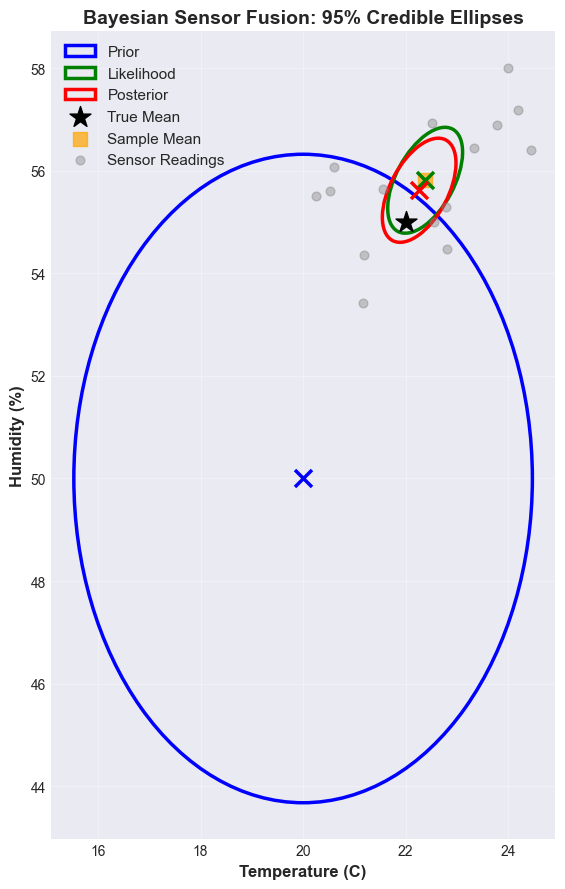


KEY OBSERVATION

Posterior ellipse is MUCH tighter than:
  - Prior (blue): we started far from truth
  - Likelihood (green): data alone still has some noise
  - Posterior (red): combines both!

Tighter = higher precision = more information about state


In [22]:
# Visualization: 95% credible ellipses
from matplotlib.patches import Ellipse

def plot_gaussian_2d(ax, mean, cov, color, label, n_std=2):
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    eigenvalues = np.sqrt(eigenvalues)
    angle = np.rad2deg(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))

    ell = Ellipse(mean,
                  width=n_std * eigenvalues[0] * 2,
                  height=n_std * eigenvalues[1] * 2,
                  angle=angle,
                  facecolor='none',
                  edgecolor=color,
                  linewidth=2.5,
                  label=label)
    ax.add_patch(ell)
    ax.scatter(*mean, c=color, s=150, marker='x', zorder=10, linewidths=2.5)

fig, ax = plt.subplots(figsize=(11, 9))

# Prior
plot_gaussian_2d(ax, mu_0_vec, Sigma_0, 'blue', 'Prior', n_std=2)

# Likelihood
likelihood_cov = true_cov / n_readings
plot_gaussian_2d(ax, sample_mean, likelihood_cov, 'green', 'Likelihood', n_std=2)

# Posterior
plot_gaussian_2d(ax, mu_n, Sigma_n, 'red', 'Posterior', n_std=2)

# True and sample means
ax.scatter(*true_mean, c='black', s=250, marker='*', label='True Mean', zorder=10)
ax.scatter(sample_mean[0], sample_mean[1], c='orange', s=100, marker='s',
           label='Sample Mean', zorder=9, alpha=0.7)

# Data points
ax.scatter(sensor_readings[:, 0], sensor_readings[:, 1],
           c='gray', s=40, alpha=0.4, label='Sensor Readings')

ax.set_xlabel('Temperature (C)', fontsize=12, fontweight='bold')
ax.set_ylabel('Humidity (%)', fontsize=12, fontweight='bold')
ax.set_title('Bayesian Sensor Fusion: 95% Credible Ellipses',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='upper left')
ax.grid(alpha=0.3)
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("KEY OBSERVATION")
print("="*60)
print(f"\nPosterior ellipse is MUCH tighter than:")
print(f"  - Prior (blue): we started far from truth")
print(f"  - Likelihood (green): data alone still has some noise")
print(f"  - Posterior (red): combines both!")
print(f"\nTighter = higher precision = more information about state")

In [23]:
print(np.linalg.inv(true_cov))

[[ 0.69565217 -0.26086957]
 [-0.26086957  0.34782609]]
